In [3]:
import numpy as np 
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset

import torch.optim as optim
from tqdm import tqdm
import copy

from sklearn.metrics import confusion_matrix, classification_report,f1_score
import seaborn as sns

# Data

***Load MNIST from pyTorch***

In [4]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='/data',
                               train=True,
                               download=True,
                               transform=transform)

test_dataset = datasets.MNIST(root='/data',
                              train=False,
                              download=True,
                              transform=transform)

val_size = int(0.3  * len(test_dataset))
test_size = len(test_dataset)-val_size
test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.13MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.40MB/s]


In [5]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

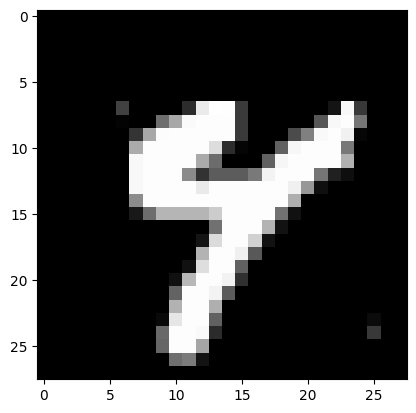

In [6]:
data_iter = iter(train_loader)
image, label = next(data_iter)

image_np = image[1].squeeze().numpy()

plt.imshow(image_np, cmap='gray')
plt.show()

# Model

## Simple CNN model

### Create model

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # 1. convolutional layers
        # 1.1.1 layer input channels = 3 like color, output channels = 8
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=7, padding=3, stride=2)
        # 1.1.2 Batch normalization for training stability
        self.bn1 = nn.BatchNorm2d(num_features=8)
        
        # 1.2 second convolution layer and Batch normalization
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(num_features=16)

        # 1.3 third convolution layer and Batch normalization
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        # 2. MaxPool for reduce the dimensionality and select importance deatures
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 3. Fully Connected layers 
        self.fc1 = nn.Linear(32 * 3 * 3, 512) 
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Create one-dimensional array
        x = x.view(-1, 32 * 3 * 3) 
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [8]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, patience, scheduler):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0
    
    model.to(device)

    # Train block
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
        train_loss /= total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
    
        # Validation block
        model.eval()
        val_loss, correct, total = 0.0,0,0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
            
                val_loss += loss.item()  * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
    
        val_loss /= total
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Train loss: {train_loss:.4f} Acc: {train_accuracy:.4f} |"
              f"Val loss: {val_loss:.4f} Acc: {val_accuracy:.4f}")
        scheduler.step()
        
        # Early stop
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            iter_without_improvements = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else: 
            iter_without_improvements += 1
            if iter_without_improvements > patience:
                model.load_state_dict(best_model_wts)
                break
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Training

In [ ]:
# 1.Initialization model
model = SimpleCNN()

# 2.Loss function 
criterion = nn.CrossEntropyLoss()

# 3.Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# 4.Train params
num_epochs = 70
patience = 5

model_my_CNN, train_losses_my_CNN, train_accuracies_my_CNN, val_losses_my_CNN, val_accuracies_my_CNN = train_model(model, 
                      train_loader, val_loader, 
                      num_epochs, criterion, optimizer, patience, scheduler)

Epoch 1


100%|██████████| 47/47 [00:00<00:00, 83.49it/s]


Train loss: 0.1493 Acc: 0.9549 |Val loss: 0.0712 Acc: 0.9783
Epoch 2


100%|██████████| 47/47 [00:00<00:00, 84.34it/s]


Train loss: 0.0524 Acc: 0.9833 |Val loss: 0.0394 Acc: 0.9880
Epoch 3


100%|██████████| 47/47 [00:00<00:00, 84.26it/s] 


Train loss: 0.0387 Acc: 0.9882 |Val loss: 0.0278 Acc: 0.9913
Epoch 4


100%|██████████| 47/47 [00:00<00:00, 83.85it/s]


Train loss: 0.0301 Acc: 0.9901 |Val loss: 0.0362 Acc: 0.9897
Epoch 5


100%|██████████| 47/47 [00:00<00:00, 81.74it/s]


Train loss: 0.0252 Acc: 0.9919 |Val loss: 0.0262 Acc: 0.9920
Epoch 6


100%|██████████| 47/47 [00:00<00:00, 81.27it/s]


Train loss: 0.0199 Acc: 0.9938 |Val loss: 0.0203 Acc: 0.9927
Epoch 7


100%|██████████| 47/47 [00:00<00:00, 73.90it/s]


Train loss: 0.0152 Acc: 0.9952 |Val loss: 0.0342 Acc: 0.9903
Epoch 8


100%|██████████| 47/47 [00:00<00:00, 71.35it/s]


Train loss: 0.0121 Acc: 0.9962 |Val loss: 0.0382 Acc: 0.9900
Epoch 9


100%|██████████| 47/47 [00:00<00:00, 84.02it/s]


Train loss: 0.0095 Acc: 0.9970 |Val loss: 0.0333 Acc: 0.9917
Epoch 10


100%|██████████| 47/47 [00:00<00:00, 83.12it/s]


Train loss: 0.0066 Acc: 0.9978 |Val loss: 0.0351 Acc: 0.9920
Epoch 11


100%|██████████| 47/47 [00:00<00:00, 83.57it/s]


Train loss: 0.0050 Acc: 0.9985 |Val loss: 0.0353 Acc: 0.9900
Epoch 12


100%|██████████| 47/47 [00:00<00:00, 84.60it/s]

Train loss: 0.0029 Acc: 0.9991 |Val loss: 0.0292 Acc: 0.9927


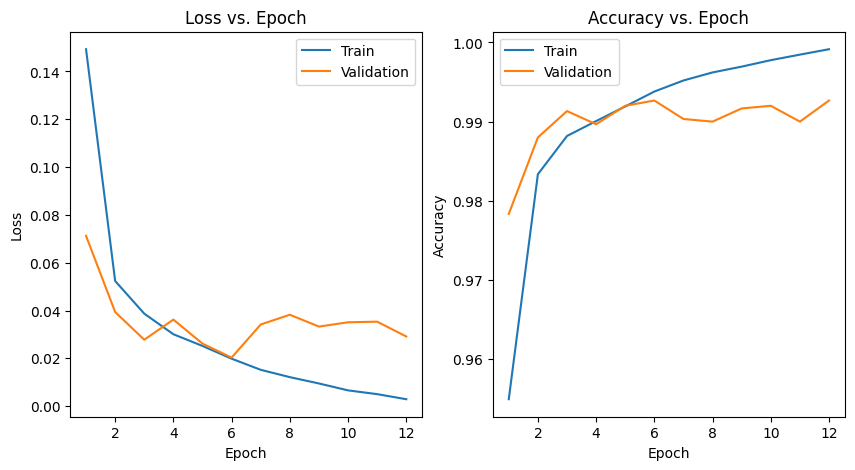

In [ ]:
# Model training/validation graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_my_CNN)+1), train_losses_my_CNN, label='Train')
plt.plot(range(1, len(val_losses_my_CNN)+1), val_losses_my_CNN, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies_my_CNN)+1), train_accuracies_my_CNN, label='Train')
plt.plot(range(1, len(val_accuracies_my_CNN)+1), val_accuracies_my_CNN, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [ ]:
# Model prediction result
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    # Calcs f1 weighted score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

# Visualisation confusion matrix
def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):  
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

### Graph result

Metrics for current model:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       695
           1       0.99      1.00      0.99       750
           2       0.98      0.99      0.99       727
           3       1.00      0.98      0.99       708
           4       0.99      0.99      0.99       669
           5       0.98      1.00      0.99       636
           6       0.99      0.98      0.99       696
           7       0.98      0.99      0.99       713
           8       1.00      0.98      0.99       698
           9       0.98      0.98      0.98       708

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000

Test Accuracy: 0.9880


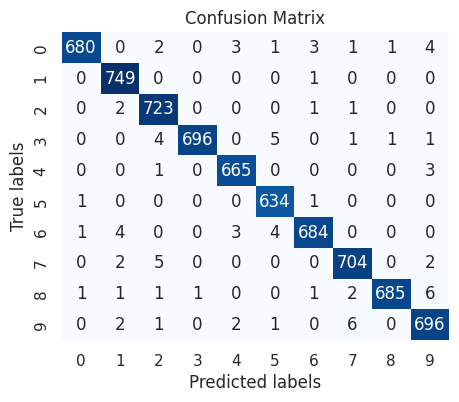

In [13]:
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model_my_CNN, test_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(10)))

### How works model

In [14]:
test_image = image[20].unsqueeze(0)

model_my_CNN.eval()

with torch.no_grad():
    x = model_my_CNN.conv1(test_image)
    x = model_my_CNN.bn1(x)

    feature_maps = F.relu(x)

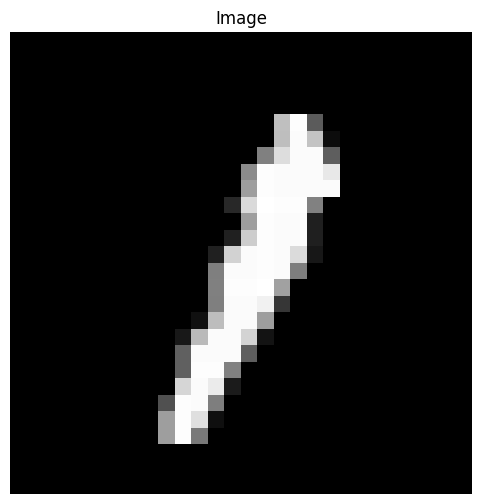

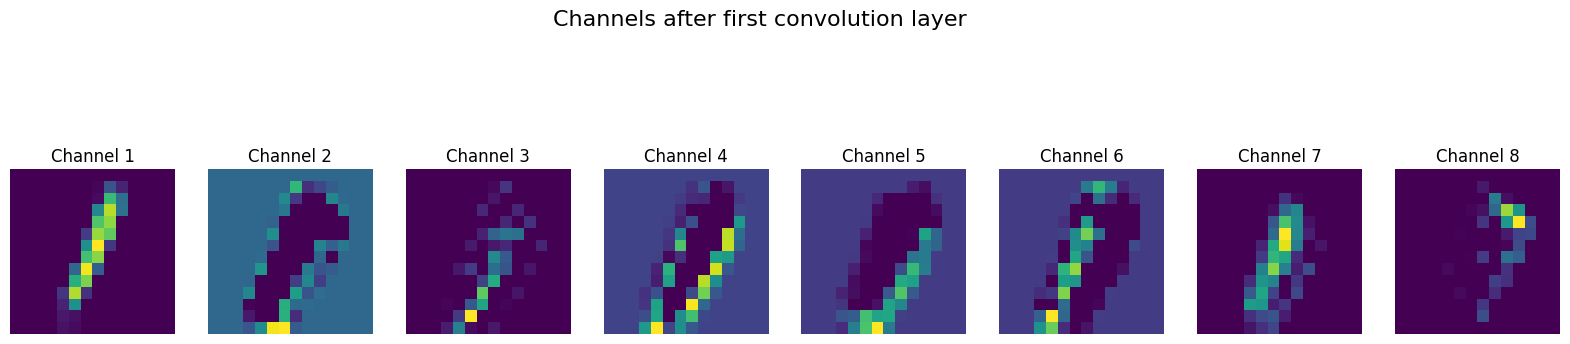

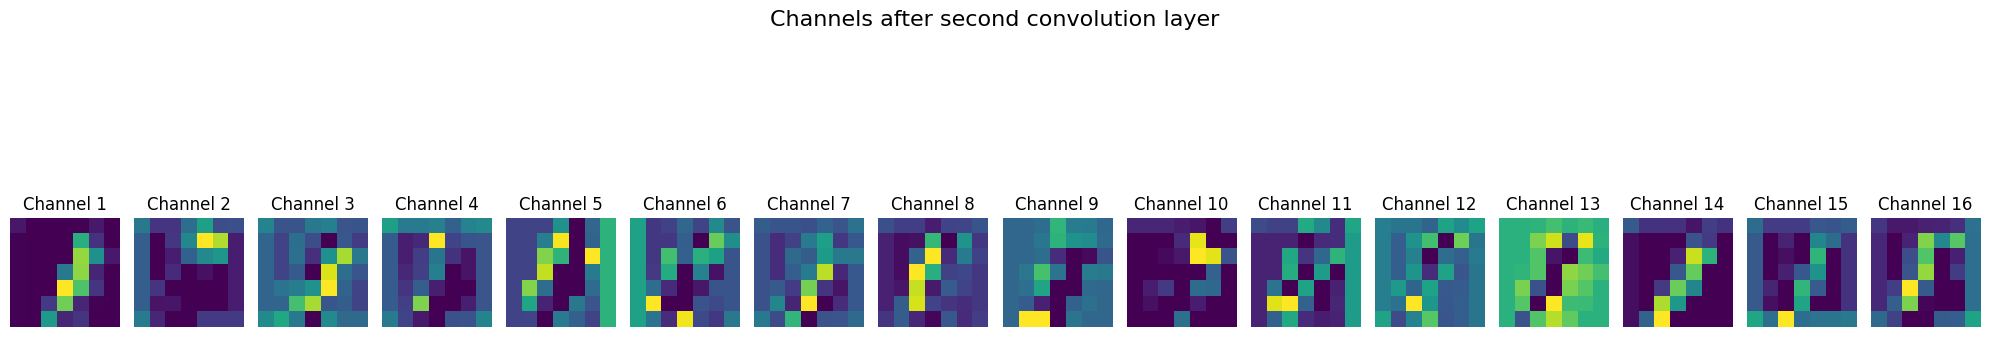

In [15]:
test_image = image[5].unsqueeze(0)

model_my_CNN.eval()

with torch.no_grad():
    x_1 = model_my_CNN.conv1(test_image)
    x_1 = model_my_CNN.bn1(x_1)
    feature_maps_1 = F.relu(x_1)
    
feature_maps_1 = feature_maps_1.squeeze(0).cpu().numpy()

with torch.no_grad():
    x_2 = model_my_CNN.conv1(test_image)
    x_2 = model_my_CNN.bn1(x_2)
    x_2 = F.relu(x_2)
    x_2 = model_my_CNN.conv2(x_2)
    x_2 = model_my_CNN.bn2(x_2)
    x_2 = F.relu(x_2)
    x_2 = model_my_CNN.pool(x_2)
    feature_maps_2 = x_2 

feature_maps_2 = feature_maps_2.squeeze(0).cpu().numpy()

# Visualisation image
plt.figure(figsize=(6, 6))
plt.imshow(test_image.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
plt.title('Image')
plt.axis('off')
plt.show()

# Visualisation channels
num_feature_maps_1 = feature_maps_1.shape[0]
fig, axs = plt.subplots(1, num_feature_maps_1, figsize=(20, 5))
fig.suptitle('Channels after first convolution layer', fontsize=16)

for i in range(num_feature_maps_1):
    ax = axs[i]
    ax.imshow(feature_maps_1[i], cmap='viridis')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

num_feature_maps_2 = feature_maps_2.shape[0]
fig, axs = plt.subplots(1, num_feature_maps_2, figsize=(20, 5))
fig.suptitle('Channels after second convolution layer', fontsize=16)

for i in range(num_feature_maps_2):
    ax = axs[i]
    ax.imshow(feature_maps_2[i], cmap='viridis')
    ax.set_title(f'Channel {i+1}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()